# Phrases

So far we have only thought in terms of single words: "lower", "lobe", "University", "of", "Utah". But in reality often times multiple words form one unit of thought: "University of Utah". Our word vectors will do a better job of representing our text if we fist recognize these phrases. We are going to use the [gensim](https://radimrehurek.com/gensim/models/phrases.html) package to detect and transform these phrases.

For example, the sentence, "I am a faculty member in the departments of Biomedical Informatics and Radiology and Imaging Sciences at the University of Utah." would be transformed to "I am a faculty member in the departments of Biomedical_Informatics and Radiology_and_Imaging_Sciences at the University_of_Utah."

"Biomedical_Informatics is an example of a **bigram phrase** and "University_of_Utah" is a **trigram phrase**. I guess "Radiology_and_Imaging_Sciences" is a quadgram phrase, but we will likely not try to detect phrases that long.

# Using the Gensim Phrases Module

In [1]:
%matplotlib inline

In [2]:
from nose.tools import assert_almost_equal, assert_true, assert_equal, assert_raises
from numbers import Number

## Upgrade to the latest version of gensim

In [3]:
#!conda install gensim -y

In [4]:
import pymysql
import pandas as pd
import getpass
from textblob import TextBlob
import re
from gensim.models.phrases import Phraser, Phrases
from IPython.display import clear_output, display, HTML
import seaborn as sns

In [5]:
import gensim
gensim.__version__

'3.1.0'

In [6]:
conn = pymysql.connect(host="mysql",
                       port=3306,user="jovyan",
                       passwd=getpass.getpass("Enter MySQL passwd for jovyan"),db='mimic2')
cursor = conn.cursor()

Enter MySQL passwd for jovyan········


## Select Some Text from the MIMIC2 Database

In [7]:
rad_data = \
pd.read_sql("""SELECT noteevents.subject_id, 
                      noteevents.hadm_id,
                      noteevents.text 
               FROM noteevents
               WHERE noteevents.category = 'RADIOLOGY_REPORT' LIMIT 5000""",conn)
rad_data.head(5)

,subject_id,hadm_id,text
0,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...
1,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...
2,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:43 AM\n ...
3,56,28766.0,\n\n\n DATE: [**2644-1-17**] 6:37 AM\n ...
4,56,28766.0,\n\n\n DATE: [**2644-1-19**] 12:09 PM\n ...


In [8]:
rad_data.shape

(5000, 3)

### Define Regular expressions for data cleansing

* Write a regular expression to replace dates in the reports with ``[**DATE**]``
* Write a regular expression to replace times in the reports with ``[**TIME**]``
* Write a regular expression to replaces digits with "d", (e.g. "43 cc" would become "dd cm")

#### Hints, etc.

* Look at some sample reports to see what dates and times look like in the reports
* What order would you need to apply the regular expressions?
* Could we just replace use the digit recognizer and skip the date and time strippers?

In [9]:
rd = re.compile(r"""\d""")

### Write a function to pre-process our text

* Lower case?
* Digits?
* Strip dates/times?

### But first, write unit tests to test whether `preprocess` is functioning correctly
#### Then write functionality to pass tests

You might want to use the `strings` module

In [22]:
import string
string.ascii_uppercase

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [31]:
def preprocess(txt):
    return rd.sub("d",txt).lower()

In [32]:
assert_true(type(preprocess("my name"))== str)

In [33]:
assert_equal(set("0123456789").intersection(
    preprocess("The patient is a 79-year-old male.")), set([]))

In [34]:
set("0123456789")


{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [35]:
assert_equal(set(string.ascii_uppercase).intersection(
    preprocess("The patient is a 79-year-old male.")), set([]))

## Create a TextBlob from all the text in `rad_data["text"]`

In [36]:
blob = TextBlob(preprocess(" ".join(rad_data["text"])))


## Write a function `train_phrases` that will train bigram and trigram detectors

* We want to be able to ignore common terms in our phrase detection
* We want to be able to specify the minimum number of occurences in our text to be considered a phrase
* Return a dictionary of detectors

### Write unit tests to determine whether `train_phrases` is working as expected

In [37]:
def train_phrases(blob, common_terms=None, min_count=5):
    sentences = [s.words for s in blob.sentences]
    if common_terms == None:
        common_terms = []
    phrases = Phrases(sentences, common_terms=common_terms, 
                      min_count=min_count)
    bigram = Phraser(phrases)
    trigram = Phrases(bigram[sentences])
    
    return {"bigram":bigram, "trigram":trigram}
        

In [38]:
common_terms = ["of", "with", "without", "and", "or", "the", "a"]
generators = train_phrases(blob, common_terms=common_terms, min_count=5)

### Write a function that takes a `TextBlob` instance and phrase generators and returns a string of text
#### Unit tests first

In [46]:
def get_phrased_text(blob, generators):
    
    return " ".join([w for s in blob.sentences \
                for w in generators["trigram"][generators["bigram"][s.tokens]] ])
    pass

In [52]:
get_phrased_text(TextBlob("There is a mass in the left lower lobe"), 
                generators)

/opt/conda/lib/python3.5/site-packages/gensim/models/phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


'There is a mass in the left lower_lobe'

In [44]:
assert_true(type(get_phrased_text(TextBlob("my name"), generators))== str)


In [50]:
assert_true("lower_lobe" in get_phrased_text(TextBlob("There is a mass in the left lower lobe"), 
                generators))

/opt/conda/lib/python3.5/site-packages/gensim/models/phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [54]:
phrased_txt = get_phrased_text(blob, generators)

/opt/conda/lib/python3.5/site-packages/gensim/models/phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## What phrases did we detect?

In [55]:
found_phrases = set([w for w in phrased_txt.split() if "_" in w])
print(len(found_phrases))

7223


In [56]:
found_phrases

{'bibasilar_subsegmental_atelectasis',
 'y/o_male_s/p',
 'bone_windows_show',
 'carotid_arteries',
 'stereotactic_brain_biopsy',
 'at_cd-d_and_cd-d',
 'evidence_of_diverticulitis',
 'french_internal/external_biliary_drain',
 'cardiac_and_mediastinal_contours',
 'french_arrow_sheath',
 'include_dopplers',
 'cath_place',
 'needs_amputation',
 'celiac_trunk',
 'rounded_focus',
 'increased_secretions',
 'man_with_cad/dvd',
 'mediastinal_contours',
 'd.ddd_guidewire',
 'c/b_respiratory_decompensation',
 'fairly_marked',
 'kidney_measures',
 'mets.gatric_ca_resected',
 'thigh_pain',
 'tunneling_device',
 'images_were_obtained_before',
 'abnormally_dilated',
 'ddm_s/p_stroke',
 'distal_common_bile',
 'hydronephrosis_or_perinephric',
 'ligamentous_injury',
 'therapeutic_thoracentesis',
 'lytic_or_sclerotic_lesions',
 'plantar_arch',
 'fluid_status',
 'duplex_dop',
 'upon_the_return',
 'aortic_stenosis',
 'ileus_vs',
 'ld_and_ld',
 'immediately_after_establishing_intravenous',
 'cut_off',
 's/p

### How often did each phrase occur?

In [57]:
from collections import Counter

In [61]:
phrased_blob = TextBlob(phrased_txt)

In [63]:
counted_phrases = Counter(phrased_blob.words)
counted_phrases

Counter({'bibasilar_subsegmental_atelectasis': 7,
         'antecubital': 8,
         'cerclage': 3,
         'hemispheric': 15,
         'cement': 1,
         'y/o_male_s/p': 9,
         'patency': 70,
         'bone_windows_show': 22,
         'patent': 799,
         'd.ddd': 52,
         'lump': 5,
         'carotid_arteries': 21,
         'stereotactic_brain_biopsy': 12,
         'evidence_of_diverticulitis': 27,
         'conclusion': 140,
         'cardiac_and_mediastinal_contours': 29,
         'oval-shaped': 3,
         'include_dopplers': 6,
         'needs_amputation': 12,
         'foramina': 2,
         'dilation': 102,
         'increased_secretions': 13,
         'likey': 1,
         'tubed': 5,
         'vis': 2,
         'mediastinal_contours': 21,
         'd.ddd_guidewire': 32,
         'relative': 37,
         'd/d': 16,
         'kidney_measures': 9,
         'thigh_pain': 8,
         'infiltrate/chf': 4,
         'images_were_obtained_before': 9,
         'withut':

In [64]:
def sorted_counter(cntr):
    lcntr = list(cntr.items())
    lcntr.sort(key=lambda x:x[1], reverse=True)
    return lcntr

In [65]:
lcounted_phrases = sorted_counter(counted_phrases)

In [67]:
for phrase, count in lcounted_phrases[:100]:
    print("%s\t%03d"%(phrase.ljust(40),count))


the                                     	63284
of                                      	28776
and                                     	23484
is                                      	23112
dd                                      	23044
with                                    	18037
in                                      	15639
d                                       	14372
for                                     	13816
right                                   	13236
a                                       	12930
there                                   	12731
clip                                    	11806
to                                      	11654
was                                     	11538
reason                                  	10744
left                                    	9970
no                                      	9589
are                                     	9470
chest                                   	6927
number                                  	6193
date              

## Create a word vector vocabulary using only words and phrases that occur more than N times
### How to choose N?

### What is our vocabulary from phrased_txt (how many unqiue words)?

Why use `TextBlob.words` instead of just `phrased_txt.split()`?

#### why is `phrased_blob = TextBlob(phrased_txt)` fast and `print(len(set(phrased_blob.words)))` slow?

In [44]:
phrased_blob = TextBlob(phrased_txt)

In [45]:
print(len(set(phrased_blob.words)))

14352


In [69]:
lcounted_phrases[-1000:]

[('compatdble', 1),
 ('pyloris', 1),
 ('corticomedullary', 1),
 ('communited', 1),
 ('previously-suspected', 1),
 ('hypoalbuminemic', 1),
 ('limbs', 1),
 ('street', 1),
 ('wall_hernia', 1),
 ('subclavian_cv', 1),
 ('fifty-two', 1),
 ('negat', 1),
 ('temporal/occipital', 1),
 ('non-rotated', 1),
 ('apicolateral', 1),
 ('fibronodular', 1),
 ('hrdd', 1),
 ('nste', 1),
 ('calvicular', 1),
 ('approximently', 1),
 ('inominant', 1),
 ('mucin', 1),
 ('pre-curved', 1),
 ('formal', 1),
 ('convenience', 1),
 ('grade-i', 1),
 ('infarct/subtle', 1),
 ('atlanto', 1),
 ('sapheno-femoral', 1),
 ('iac', 1),
 ('wob', 1),
 ('goes', 1),
 ('annular', 1),
 ('infiltrates-patient', 1),
 ('continously', 1),
 ('diagnostic/therapeutic', 1),
 ('excludes', 1),
 ('ddemonstrated', 1),
 ('enthesophytes', 1),
 ('nonacute', 1),
 ('schrapnel', 1),
 ('malleolus', 1),
 ('chest/uppe', 1),
 ('calcifying', 1),
 ('microperf', 1),
 ('mos', 1),
 ('appearance.the', 1),
 ('w/resection', 1),
 ('minimole', 1),
 ('distiguish', 1),
 

In [51]:
phrased_blob_count = None


In [73]:
stop_words = ["the", "of", "and", "is", "dd", "with", "in", "for", "a", "to", "was", "are"]

In [63]:
phrased_blob_count[:100]

[('the', 66813),
 ('of', 31330),
 ('and', 26718),
 ('is', 23112),
 ('dd', 23044),
 ('with', 19417),
 ('in', 15639),
 ('d', 14372),
 ('for', 13816),
 ('a', 13578),
 ('right', 13236),
 ('there', 12731),
 ('to', 12083),
 ('was', 11927),
 ('clip', 11825),
 ('no', 11030),
 ('reason', 10744),
 ('left', 10039),
 ('are', 9959),
 ('contrast', 9078),
 ('chest', 7713),
 ('number', 6193),
 ('date', 6184),
 ('radiology', 6087),
 ('ct', 5741),
 ('dddd', 5520),
 ('dddd-d-dd', 4812),
 ('this_examination', 4562),
 ('ddddd', 4506),
 ('on', 4500),
 ('underlying_medical_condition', 4489),
 ('impression', 4157),
 ('at', 4098),
 ('or', 4023),
 ('seen', 3975),
 ('final_report', 3917),
 ('ddd', 3825),
 ('within', 3587),
 ('pm', 3501),
 ('catheter', 3366),
 ('name', 3295),
 ('patient', 3210),
 ('admitting_diagnosis', 3137),
 ('this', 3075),
 ('td', 2983),
 ('from', 2950),
 ('evidence', 2830),
 ('am', 2813),
 ('year_old_man', 2664),
 ('abdomen', 2554),
 ('over', 2523),
 ('small', 2370),
 ('dddd-d-d', 2351),
 ('

### Based on these most frequent words, create a list of stop words to drop from our vocabulary

In [70]:
stop_words = []

### What are our infrequent words?

In [62]:
phrased_blob_count[-2000:-1000]

[('work', 1),
 ('dilution', 1),
 ('sanguinous', 1),
 ('grinds', 1),
 ('ddds-ddds', 1),
 ('indirect', 1),
 ('vasculaturewhich', 1),
 ('delta', 1),
 ('inhomogeneous', 1),
 ('avr/mvr/tv', 1),
 ('multicompartmental', 1),
 ('protracted', 1),
 ('isodense', 1),
 ('sacular', 1),
 ('orphan', 1),
 ('annular', 1),
 ('atrophied', 1),
 ('cerebralr', 1),
 ('posteroinferior', 1),
 ('mucoperiosteal', 1),
 ('ivrn', 1),
 ('himself', 1),
 ('distances', 1),
 ('subscapularis', 1),
 ('aveolar', 1),
 ('retrocalcaneal', 1),
 ('dislocates', 1),
 ('chest/abdomen', 1),
 ('padding', 1),
 ('block\\pacemaker', 1),
 ('mra/mri', 1),
 ('cardiomyeopathy', 1),
 ('wi', 1),
 ('opacifiactions', 1),
 ('avr/mvr/tvrepair', 1),
 ('myocardial', 1),
 ('rotablation', 1),
 ('lymphadopathy', 1),
 ('disida', 1),
 ('enterocutaneous', 1),
 ('additon', 1),
 ('underdialysis', 1),
 ('ambulation', 1),
 ('eyelid', 1),
 ('w/palpation', 1),
 ('ostium', 1),
 ('choking', 1),
 ('fliod', 1),
 ('cholestatic', 1),
 ('rehydrated', 1),
 ('respir', 1

In [71]:
len(lcounted_phrases)

17101

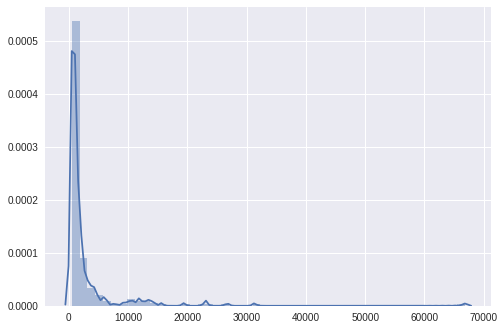

In [60]:
sns.distplot([c[1] for c in phrased_blob_count if c[1] > 500])

In [70]:
len([w for w in lcounted_phrases if w[1]>10])

6314

In [77]:
vwords = [w for w in lcounted_phrases if w[1]>100 and w[0] not in stop_words]

In [78]:
len(vwords)

894

### Determining Similarity Between Reports
* CXR vs CT vs MR

In [77]:
rad_data[rad_data["text"].str.contains("MRI")]

,subject_id,hadm_id,text
0,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...
1,56,28766.0,\n\n\n DATE: [**2644-1-17**] 10:53 AM\n ...
29,61,7149.0,\n\n\n DATE: [**3352-7-19**] 9:38 AM\n ...
30,61,7149.0,\n\n\n DATE: [**3352-7-19**] 9:38 AM\n ...
31,61,7149.0,\n\n\n DATE: [**3352-7-19**] 9:38 AM\n ...
40,61,NaN,\n\n\n DATE: [**3352-11-26**] 4:10 PM\n ...
41,61,NaN,\n\n\n DATE: [**3352-11-26**] 4:10 PM\n ...
42,61,NaN,\n\n\n DATE: [**3352-11-26**] 4:10 PM\n ...
43,61,NaN,\n\n\n DATE: [**3352-11-26**] 4:10 PM\n ...
157,21,20882.0,\n\n\n DATE: [**3139-3-21**] 2:01 PM\n ...


## Create a Report Browser

In [ ]:
num_reports = rad_data.shape[0]
while True:
    try:
        i = int(input("Enter a number between 0 and %d. otherwise to quit"%num_reports))
        clear_output()

        if i < 0 or i >=num_reports:
            break
        txt = TextBlob(rd.sub("""d""", rad_data.iloc[i]['text'].strip().lower()))
        display(HTML("<>%s</p>"%" ".join(trigram_generator[bigram_generator[txt.tokens]])))
        
    except ValueError:
        break


In [ ]:
type(txt)

## Wrangling Doesn't Always Do What You Want

>technique : multiplanar_td and td-weighted_images of the brain with gadolinium_according to standard departmental protocol .